In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from scipy import stats
import random

# Standard plotly imports
import chart_studio.plotly as py
import plotly.graph_objects as go
import chart_studio.tools as tls
import plotly.tools as pls
from plotly.offline import iplot, init_notebook_mode
import cufflinks
import cufflinks as cf

#import lightgbm
from functools import partial
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING

# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
cufflinks.go_offline(connected=True)

import gc
import warnings
from itertools import product
warnings.filterwarnings("ignore")

# Importing the Datasets

In [ ]:
df_train = pd.read_csv('data\sales_train.csv')

df_categories = pd.read_csv("data\item_categories.csv")
df_items = pd.read_csv("data\items.csv")
df_shops = pd.read_csv("data\shops.csv")

df_test = pd.read_csv("data/test.csv")

In [ ]:
df_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [ ]:
df_items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


**<font color = red>Joining the tables to our train dataset</font>**

In [ ]:
df_train = pd.merge(df_train, df_items, on='item_id', how='inner')
df_train = pd.merge(df_train, df_categories, on='item_category_id', how='inner')
df_train = pd.merge(df_train, df_shops, on='shop_id', how='inner')

df_test = pd.merge(df_test, df_items, on='item_id', how='inner')
df_test = pd.merge(df_test, df_categories, on='item_category_id', how='inner')
df_test = pd.merge(df_test, df_shops, on='shop_id', how='inner')

# del df_items, df_categories, df_shops
#清理內存
gc.collect()

0

## First look at our data

In [ ]:
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,02.01.2013,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,26.04.2013,3,59,944,150.0,1.0,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
2,26.06.2013,5,59,944,199.5,1.0,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
3,20.07.2013,6,59,944,199.5,1.0,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
4,14.09.2013,8,59,944,299.0,2.0,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""


In [ ]:
dict_categories = ['Cinema - DVD', 'PC Games - Standard Editions',
                    'Music - Local Production CD', 'Games - PS3', 'Cinema - Blu-Ray',
                    'Games - XBOX 360', 'PC Games - Additional Editions', 'Games - PS4',
                    'Gifts - Stuffed Toys', 'Gifts - Board Games (Compact)',
                    'Gifts - Figures', 'Cinema - Blu-Ray 3D',
                    'Programs - Home and Office', 'Gifts - Development',
                    'Gifts - Board Games', 'Gifts - Souvenirs (on the hinge)',
                    'Cinema - Collection', 'Music - MP3', 'Games - PSP',
                    'Gifts - Bags, Albums, Mouse Pads', 'Gifts - Souvenirs',
                    'Books - Audiobooks', 'Gifts - Gadgets, robots, sports',
                    'Accessories - PS4', 'Games - PSVita',
                    'Books - Methodical materials 1C', 'Payment cards - PSN',
                    'PC Games - Digit', 'Games - Game Accessories', 'Accessories - XBOX 360',
                    'Accessories - PS3', 'Games - XBOX ONE', 'Music - Vinyl',
                    'Programs - 1C: Enterprise 8', 'PC Games - Collectible Editions',
                    'Gifts - Attributes', 'Service Tools',
                    'Music - branded production CD', 'Payment cards - Live!',
                    'Game consoles - PS4', 'Accessories - PSVita', 'Batteries',
                    'Music - Music Video', 'Game Consoles - PS3',
                    'Books - Comics, Manga', 'Game Consoles - XBOX 360',
                    'Books - Audiobooks 1C', 'Books - Digit',
                    'Payment cards (Cinema, Music, Games)', 'Gifts - Cards, stickers',
                    'Accessories - XBOX ONE', 'Pure media (piece)',
                    'Programs - Home and Office (Digital)', 'Programs - Educational',
                    'Game consoles - PSVita', 'Books - Artbooks, encyclopedias',
                    'Programs - Educational (Digit)', 'Accessories - PSP',
                    'Gaming consoles - XBOX ONE', 'Delivery of goods',
                    'Payment Cards - Live! (Figure) ',' Tickets (Figure) ',
                    'Music - Gift Edition', 'Service Tools - Tickets',
                    'Net media (spire)', 'Cinema - Blu-Ray 4K', 'Game consoles - PSP',
                    'Game Consoles - Others', 'Books - Audiobooks (Figure)',
                    'Gifts - Certificates, Services', 'Android Games - Digit',
                    'Programs - MAC (Digit)', 'Payment Cards - Windows (Digit)',
                    'Books - Business Literature', 'Games - PS2', 'MAC Games - Digit',
                    'Books - Computer Literature', 'Books - Travel Guides',
                    'PC - Headsets / Headphones', 'Books - Fiction',
                    'Books - Cards', 'Accessories - PS2', 'Game consoles - PS2',
                    'Books - Cognitive literature']

dict_shops = ['Moscow Shopping Center "Semenovskiy"', 
              'Moscow TRK "Atrium"', 
              "Khimki Shopping Center",
              'Moscow TC "MEGA Teply Stan" II', 
              'Yakutsk Ordzhonikidze, 56',
              'St. Petersburg TC "Nevsky Center"', 
              'Moscow TC "MEGA Belaya Dacha II"',
              'Voronezh (Plekhanovskaya, 13)', 
              'Yakutsk Shopping Center "Central"',
              'Chekhov SEC "Carnival"', 
              'Sergiev Posad TC "7Ya"',
              'Tyumen TC "Goodwin"',
              'Kursk TC "Pushkinsky"', 
              'Kaluga SEC "XXI Century"',
              'N.Novgorod Science and entertainment complex "Fantastic"',
              'Moscow MTRC "Afi Mall"',
              'Voronezh SEC "Maksimir"', 'Surgut SEC "City Mall"',
              'Moscow Shopping Center "Areal" (Belyaevo)', 'Krasnoyarsk Shopping Center "June"',
              'Moscow TK "Budenovsky" (pav.K7)', 'Ufa "Family" 2',
              'Kolomna Shopping Center "Rio"', 'Moscow Shopping Center "Perlovsky"',
              'Moscow Shopping Center "New Century" (Novokosino)', 'Omsk Shopping Center "Mega"',
              'Moscow Shop C21', 'Tyumen Shopping Center "Green Coast"',
              'Ufa TC "Central"', 'Yaroslavl shopping center "Altair"',
              'RostovNaDonu "Mega" Shopping Center', '"Novosibirsk Mega "Shopping Center',
              'Samara Shopping Center "Melody"', 'St. Petersburg TC "Sennaya"',
              "Volzhsky Shopping Center 'Volga Mall' ",
              'Vologda Mall "Marmelad"', 'Kazan TC "ParkHouse" II',
              'Samara Shopping Center ParkHouse', '1C-Online Digital Warehouse',
              'Online store of emergencies', 'Adygea Shopping Center "Mega"',
              'Balashikha shopping center "October-Kinomir"' , 'Krasnoyarsk Shopping center "Vzletka Plaza" ',
              'Tomsk SEC "Emerald City"', 'Zhukovsky st. Chkalov 39m? ',
              'Kazan Shopping Center "Behetle"', 'Tyumen SEC "Crystal"',
              'RostovNaDonu TRK "Megacenter Horizon"',
              '! Yakutsk Ordzhonikidze, 56 fran', 'Moscow TC "Silver House"',
              'Moscow TK "Budenovsky" (pav.A2)', "N.Novgorod SEC 'RIO' ",
              '! Yakutsk TTS "Central" fran', 'Mytishchi TRK "XL-3"',
              'RostovNaDonu TRK "Megatsentr Horizon" Ostrovnoy', 'Exit Trade',
              'Voronezh SEC City-Park "Grad"', "Moscow 'Sale'",
              'Zhukovsky st. Chkalov 39m² ',' Novosibirsk Shopping Mall "Gallery Novosibirsk"']

In [ ]:
# This function is to extract date features
def date_process(df):
    df["date"] = pd.to_datetime(df["date"], format="%d.%m.%Y") # seting the column as pandas datetime
    df["_weekday"] = df['date'].dt.weekday #extracting week day
    df["_day"] = df['date'].dt.day # extracting day
    df["_month"] = df['date'].dt.month # extracting month
    
    return df #returning the df after the transformations

def cross_heatmap(df, cols, normalize=False, values=None, aggfunc=None):
    temp = cols
    cm = sns.light_palette("green", as_cmap=True)
    return pd.crosstab(df[temp[0]], df[temp[1]], 
                       normalize=normalize, values=values, aggfunc=aggfunc).style.background_gradient(cmap = cm)

def quantiles(df, columns):
    for name in columns:
        print(name + " quantiles")
        print(df[name].quantile([.01,.25,.5,.75,.99]))
        print("")

def chi2_test(col ):
    stat, p, dof, expected = stats.chi2_contingency((pd.crosstab(df_train[col], df_train.item_cnt_day)))
    # interpret test-statistic
    prob = 0.95
    critical = stats.chi2.ppf(prob, dof)
    print(f"Testing the {col} by Total Items Sold")
    print('dof=%d' % dof)
    print(p)
    print("Critical Result: ")
    if abs(stat) >= critical:
        print(f"Critical {round(critical,4)}")
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
        
    print("")
    alpha = 1.0 - prob
    print("P Value: ")
    if p <= alpha:
        print(f"P-Value: {round(p,8)}")
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
        
def log_transforms(df, cols):
    for col in cols:
        df[col+'_log'] = np.log(df[col] + 1)
    return df

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    
    return df

def knowningData(df, limit=5): #seting the function with df, 
    print(f"Dataset Shape: {df.shape}")
    print('Unique values per column: ')
    print(df.nunique())
    print("################")
    print("")    
    for column in df.columns: #initializing the loop
        print("Column Name: ", column )
        entropy = round(stats.entropy(df[column].value_counts(), base=2),2)
        print("entropy ", entropy, 
              " | Total nulls: ", (round(df[column].isnull().sum() / len(df[column]) * 100,2)),
              " | Total unique values: ", df.nunique()[column], #print the data and % of nulls
              " | Missing: ", df[column].isna().sum())
        print("Top 5 most frequent values: ")
        print(round(df[column].value_counts()[:limit] / df[column].value_counts().sum() * 100,2))
        print("")
        print("####################################")

## First look at some informations of our data
- to see the output click on "show output" button >>>

In [ ]:
knowningData(df_train)

Dataset Shape: (2935849, 10)
Unique values per column: 
date                   1034
date_block_num           34
shop_id                  60
item_id               21807
item_price            19993
item_cnt_day            198
item_name             21807
item_category_id         84
item_category_name       84
shop_name                60
dtype: int64
################

Column Name:  date
entropy  9.91  | Total nulls:  0.0  | Total unique values:  1034  | Missing:  0
Top 5 most frequent values: 
28.12.2013    0.32
29.12.2013    0.32
30.12.2014    0.32
30.12.2013    0.31
31.12.2014    0.28
Name: date, dtype: float64

####################################
Column Name:  date_block_num
entropy  5.04  | Total nulls:  0.0  | Total unique values:  34  | Missing:  0
Top 5 most frequent values: 
11    4.88
23    4.45
2     4.13
0     3.94
1     3.70
Name: date_block_num, dtype: float64

####################################
Column Name:  shop_id
entropy  5.39  | Total nulls:  0.0  | Total unique values

## Mapping our dictionary

In [ ]:
df_train.item_category_name = df_train.item_category_name.map(dict(zip(df_train.item_category_name.value_counts().index, dict_categories)))
df_train.shop_name = df_train.shop_name.map(dict(zip(df_train.shop_name.value_counts().index, dict_shops)))

## 开始探索我们的目标(item_cnt_day)，它指的是已售出的商品和商品价格

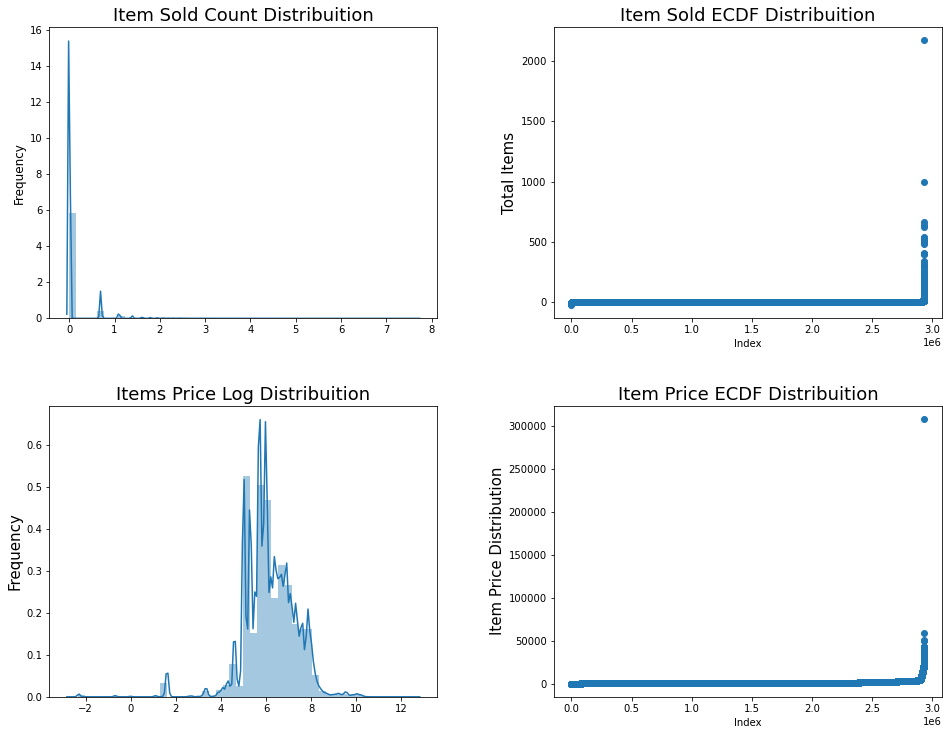

In [ ]:
plt.figure(figsize=(16,12))

plt.subplot(221)
g = sns.distplot(np.log(df_train[df_train['item_cnt_day'] >0]['item_cnt_day']))
g.set_title("Item Sold Count Distribuition", fontsize=18)
g.set_xlabel("")
g.set_ylabel("Frequency", fontsize=12)

plt.subplot(222)
g1 = plt.scatter(range(df_train.shape[0]), np.sort(df_train.item_cnt_day.values))
g1= plt.title("Item Sold ECDF Distribuition", fontsize=18)
g1 = plt.xlabel("Index")
g1 = plt.ylabel("Total Items", fontsize=15)

plt.subplot(223)
g2 = sns.distplot(np.log(df_train[df_train['item_price'] > 0]['item_price']))
g2.set_title("Items Price Log Distribuition", fontsize=18)
g2.set_xlabel("")
g2.set_ylabel("Frequency", fontsize=15)

plt.subplot(224)
g3 = plt.scatter(range(df_train.shape[0]), np.sort(df_train.item_price.values))
g3= plt.title("Item Price ECDF Distribuition", fontsize=18)
g3 = plt.xlabel("Index")
g3 = plt.ylabel("Item Price Distribution", fontsize=15)

plt.subplots_adjust(wspace = 0.3, hspace = 0.3,
                    top = 0.9)

plt.show()

## Quantiles of continuous features and target
- 新增一個每日營收的欄位

In [ ]:
df_train['total_amount'] = df_train['item_price'] * df_train['item_cnt_day']

In [ ]:
#顯示出各種百分位數
quantiles(df_train, ['item_cnt_day','item_price', 'total_amount'])

item_cnt_day quantiles
0.01    1.0
0.25    1.0
0.50    1.0
0.75    1.0
0.99    5.0
Name: item_cnt_day, dtype: float64

item_price quantiles
0.01       5.0
0.25     249.0
0.50     399.0
0.75     999.0
0.99    5999.0
Name: item_price, dtype: float64

total_amount quantiles
0.01       18.0
0.25      249.0
0.50      449.0
0.75     1078.2
0.99    11375.0
Name: total_amount, dtype: float64



## Knowing the Shop, category and items columns

Description most frequent countrys: 
Moscow Shopping Center "Semenovskiy"    235636
Moscow TRK "Atrium"                     186104
Khimki Shopping Center                  143480
Moscow TC "MEGA Teply Stan" II          142234
Yakutsk Ordzhonikidze, 56               117428
St. Petersburg TC "Nevsky Center"       109253
Moscow TC "MEGA Belaya Dacha II"        105366
Voronezh (Plekhanovskaya, 13)            82663
Yakutsk Shopping Center "Central"        71441
Chekhov SEC "Carnival"                   69573
Name: shop_name, dtype: int64


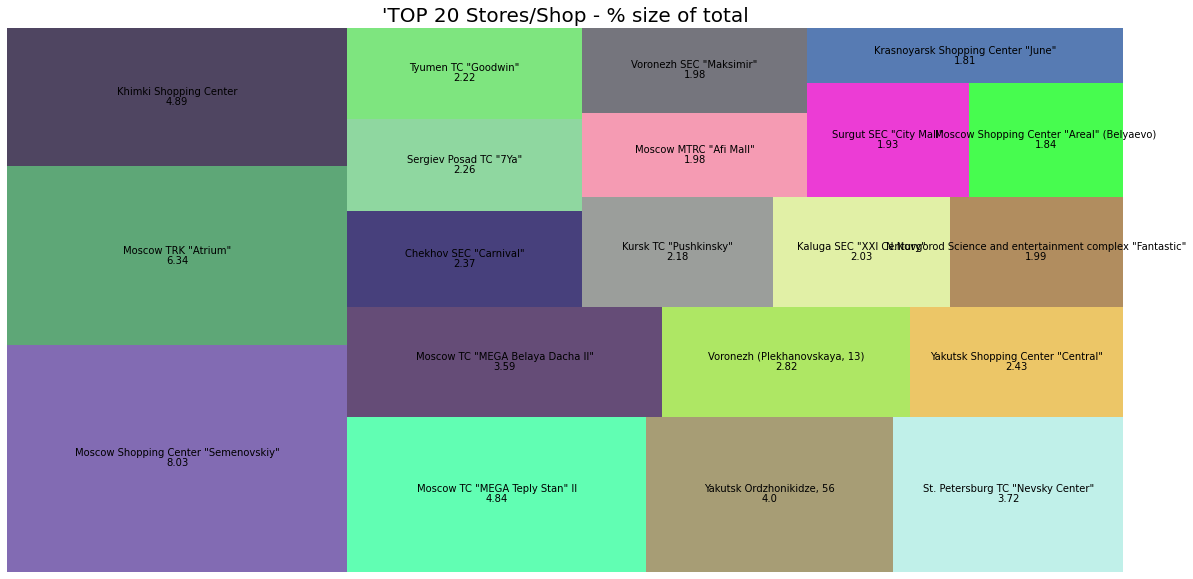

In [ ]:
import squarify

color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(30)]
shop_name = df_train["shop_name"].value_counts() #counting the values of shop names

print("Description most frequent countrys: ")
print(shop_name[:10]) #printing the 15 top most 

shop = round((df_train["shop_name"].value_counts()[:20] \
                       / len(df_train["shop_name"]) * 100),2)

plt.figure(figsize=(20,10))
g = squarify.plot(sizes=shop.values, label=shop.index, 
                  value=shop.values,
                  alpha=.8, color=color)
g.set_title("'TOP 20 Stores/Shop - % size of total",fontsize=20)
g.set_axis_off()
plt.show()

**<font color = red>沒有獨佔的商家</font>**

## Looking the Total Amount sold by the Stores

In [ ]:
df_train.groupby('shop_name')['item_price'].sum().nlargest(25)

shop_name
Moscow Shopping Center "Semenovskiy"                        1.707634e+08
Moscow TRK "Atrium"                                         1.555576e+08
Moscow TC "MEGA Teply Stan" II                              1.252947e+08
Khimki Shopping Center                                      1.096694e+08
Moscow TC "MEGA Belaya Dacha II"                            1.056489e+08
St. Petersburg TC "Nevsky Center"                           1.015515e+08
Yakutsk Ordzhonikidze, 56                                   9.131521e+07
Voronezh (Plekhanovskaya, 13)                               7.455831e+07
Tyumen TC "Goodwin"                                         6.335695e+07
Surgut SEC "City Mall"                                      6.280522e+07
Krasnoyarsk Shopping Center "June"                          6.251643e+07
Sergiev Posad TC "7Ya"                                      6.093469e+07
Yakutsk Shopping Center "Central"                           5.846344e+07
N.Novgorod Science and entertainment comp

Percentual of total sold by each Shop
shop_name
Moscow Shopping Center "Semenovskiy"    6.529125
Moscow TRK "Atrium"                     5.947730
Moscow TC "MEGA Teply Stan" II          4.790632
Khimki Shopping Center                  4.193201
Moscow TC "MEGA Belaya Dacha II"        4.039476
Name: item_price, dtype: float64


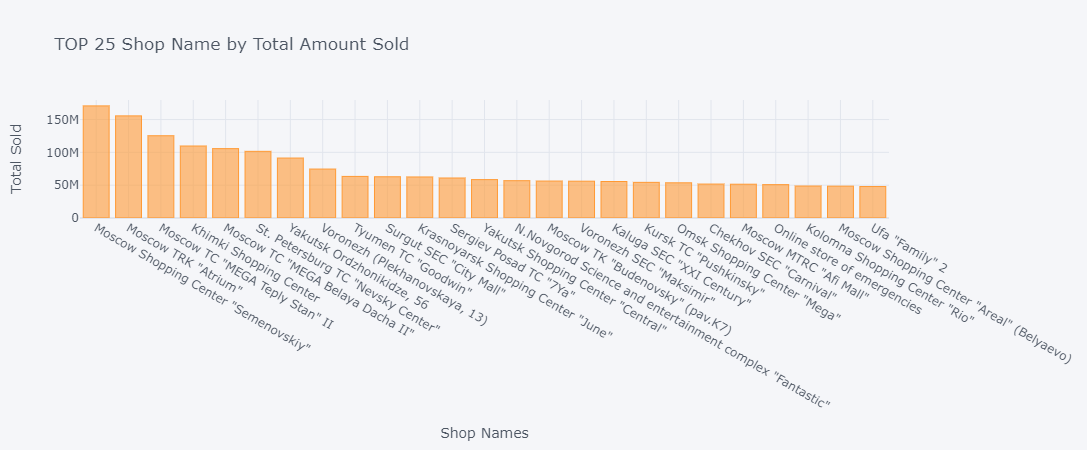

In [ ]:
print("Percentual of total sold by each Shop")
print((df_train.groupby('shop_name')['item_price'].sum().nlargest(25) / df_train.groupby('shop_name')['item_price'].sum().sum() * 100)[:5])
#%matplotlib inline
df_train.groupby('shop_name')['item_price'].sum().nlargest(25).iplot(kind='bar',
                                                                     title='TOP 25 Shop Name by Total Amount Sold',
                                                                     xTitle='Shop Names', 
                                                                     yTitle='Total Sold')

It's interesting to note that the difference in values aren't different as the total solds<br>
the difference betweeen Moscow Shopping Center and Moscow TRK aren't so different 

## The Item Solds by Shop Names

Percentual of total sold by each Shop
shop_name
Moscow Shopping Center "Semenovskiy"    8.518625
Moscow TRK "Atrium"                     6.631204
Khimki Shopping Center                  5.092640
Moscow TC "MEGA Teply Stan" II          5.058843
St. Petersburg TC "Nevsky Center"       3.972747
Name: item_cnt_day, dtype: float64


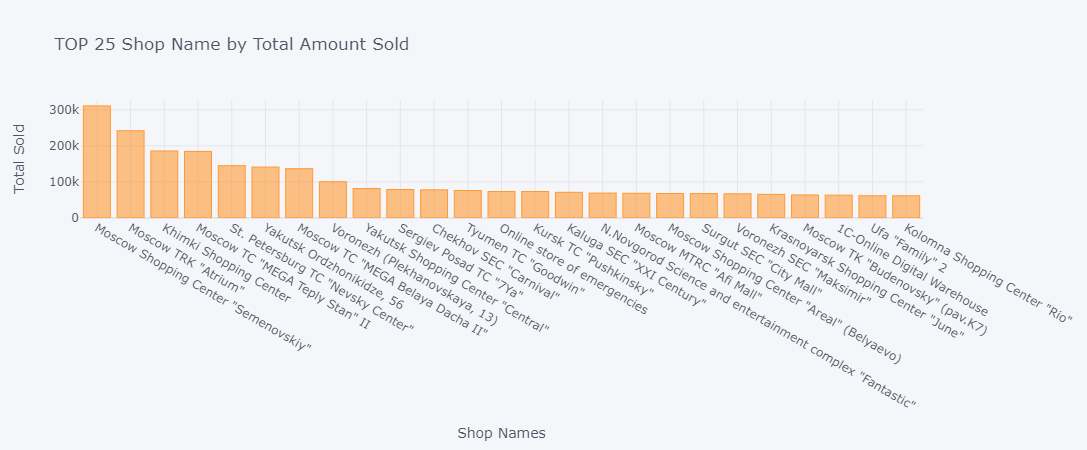

In [ ]:
print("Percentual of total sold by each Shop")
print((df_train.groupby('shop_name')['item_cnt_day'].sum().nlargest(25) / df_train.groupby('shop_name')['item_cnt_day'].sum().sum() * 100)[:5])

df_train.groupby('shop_name')['item_cnt_day'].sum().nlargest(25).iplot(kind='bar',
                                                                       title='TOP 25 Shop Name by Total Amount Sold',
                                                                       xTitle='Shop Names', 
                                                                       yTitle='Total Sold')

In [ ]:
df_train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'item_name', 'item_category_id', 'item_category_name',
       'shop_name', 'total_amount'],
      dtype='object')

In [ ]:
df_train = log_transforms(df_train, ['item_price', 'item_cnt_day', 'total_amount'])

In [ ]:
df_train[['item_cnt_day', 'item_price', 'item_name']].sort_values('item_cnt_day', ascending=False).head(20)

,item_cnt_day,item_price,item_name
2694327,2169.0,0.908714,Доставка до пункта выдачи (Boxberry)
2693208,1000.0,4.000000,Фирменный пакет майка 1С Интерес белый (34*42)...
2698367,669.0,1692.526158,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) [..."
2933626,637.0,1702.825746,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У..."
2676429,624.0,1904.548077,"Grand Theft Auto V [PC, русские субтитры]"
2694220,539.0,155.192950,Доставка до пункта выдачи (Boxberry)
2933608,533.0,1500.000000,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У..."
2697330,512.0,1500.000000,"Билет ""ИгроМир 2014"" (на один день (отдельно -..."
2917997,508.0,899.000000,"Средиземье: Тени Мордора [PC, Цифровая версия]"
2698368,504.0,1500.000000,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) [..."


## Items category
- Let's see some distributions of the top values in our data

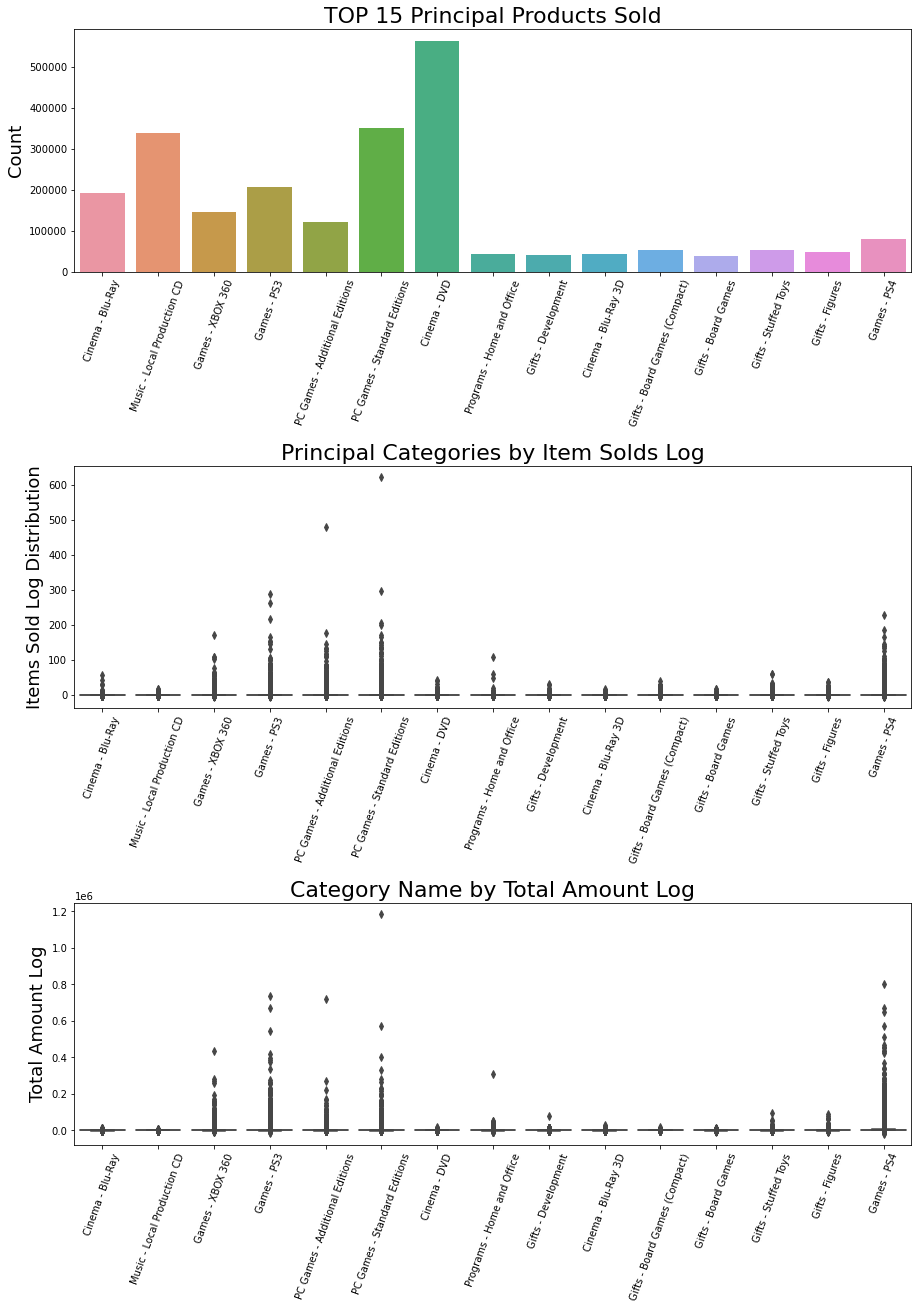

In [ ]:
top_cats = df_train.item_category_name.value_counts()[:15]

plt.figure(figsize=(15,20))

plt.subplot(311)
g1 = sns.countplot(x='item_category_name', 
                   data=df_train[df_train.item_category_name.isin(top_cats.index)])
g1.set_xticklabels(g1.get_xticklabels(),rotation=70)
g1.set_title("TOP 15 Principal Products Sold", fontsize=22)
g1.set_xlabel("")
g1.set_ylabel("Count", fontsize=18)

plt.subplot(312)
g2 = sns.boxplot(x='item_category_name', y='item_cnt_day', 
                   data=df_train[df_train.item_category_name.isin(top_cats.index)])
g2.set_xticklabels(g2.get_xticklabels(),rotation=70)
g2.set_title("Principal Categories by Item Solds Log", fontsize=22)
g2.set_xlabel("")
g2.set_ylabel("Items Sold Log Distribution", fontsize=18)

plt.subplot(313)
g3 = sns.boxplot(x='item_category_name', y='total_amount', 
                   data=df_train[df_train.item_category_name.isin(top_cats.index)])
g3.set_xticklabels(g3.get_xticklabels(),rotation=70)
g3.set_title("Category Name by Total Amount Log", fontsize=22)
g3.set_xlabel("")
g3.set_ylabel("Total Amount Log", fontsize=18)

plt.subplots_adjust(wspace = 0.2, hspace = 0.8,top = 0.9)
plt.show()

It's very meaningfull. <br>
we can see what are the most sold items and the distribution of solds. <br>
I will see the prices further and the possibility to cross our data

## Taking a look at the highest purchases in the data
- First I will create a subsample to see the outliers
- I will get top 5K highest total amounts and see if we can have some insight

In [ ]:
sub_categorys_5000 = df_train.sort_values('total_amount',
                                          ascending=False)[['item_category_name', 'item_name', 
                                                            'shop_name',
                                                            'item_cnt_day','item_price',
                                                            'total_amount']].head(5000)
sub_categorys_5000.head(10)

,item_category_name,item_name,shop_name,item_cnt_day,item_price,total_amount
1068934,Game consoles - PS4,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,"St. Petersburg TC ""Nevsky Center""",101.0,18118.712871,1.829990e+06
815919,Game consoles - PS4,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,"Moscow Shopping Center ""Semenovskiy""",90.0,18245.555556,1.642100e+06
378795,Game consoles - PS4,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,"Moscow TRK ""Atrium""",85.0,18190.000000,1.546150e+06
2695457,Game consoles - PS4,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,Online store of emergencies,84.0,18073.690476,1.518190e+06
2119997,Game consoles - PS4,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,"Krasnoyarsk Shopping Center ""June""",73.0,18305.068493,1.336270e+06
2695470,Game consoles - PS4,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,Online store of emergencies,52.0,24278.461538,1.262480e+06
465999,Game consoles - PS4,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,"Voronezh (Plekhanovskaya, 13)",67.0,18198.955224,1.219330e+06
2682591,PC Games - Collectible Editions,Ведьмак 3: Дикая охота. Коллекционное издание ...,Online store of emergencies,140.0,8499.000000,1.189860e+06
2676429,PC Games - Standard Editions,"Grand Theft Auto V [PC, русские субтитры]",Online store of emergencies,624.0,1904.548077,1.188438e+06
2698367,Service Tools - Tickets,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) [...",Online store of emergencies,669.0,1692.526158,1.132300e+06


Loking the price of PS4 I can infer that it's not about dollars.<br>
Let's see the distribution of our features in the subsample;

# Descriptions of the top 5k most exepensive sales

In [ ]:
sub_categorys_5000.describe(include='all')

,item_category_name,item_name,shop_name,item_cnt_day,item_price,total_amount
count,5000,5000,5000,5000.000000,5000.000000,5.000000e+03
unique,35,321,54,NaN,NaN,NaN
top,Game consoles - PS4,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,"Moscow TRK ""Atrium""",NaN,NaN,NaN
freq,1988,1460,383,NaN,NaN,NaN
mean,NaN,NaN,NaN,17.900400,12833.009561,7.686763e+04
std,NaN,NaN,NaN,36.256439,11246.963467,1.043254e+05
min,NaN,NaN,NaN,1.000000,155.192950,3.020150e+04
25%,NaN,NaN,NaN,2.000000,2753.370629,3.789975e+04
50%,NaN,NaN,NaN,8.000000,10490.000000,4.798400e+04
75%,NaN,NaN,NaN,20.000000,22490.000000,7.296000e+04


Very cool!! We can see that the most expensive item Price is 308k and the highest item sold a

## Total revenue Representation of total sales

In [ ]:
print("TOTAL REPRESENTATION OF TOP 5k Most Expensive orders: ", 
      f'{round((sub_categorys_5000.item_price.sum() / df_train.item_price.sum()) * 100, 2)}%')


TOTAL REPRESENTATION OF TOP 5k Most Expensive orders:  2.45%


Altough it contains high values, the top 5k most expensive bills represents just 2.45% of total amount sold. <br>
I think that it happens because are retails shops that sells to "normal" people and not other business


## Shops and items categorys of the most expensive trades

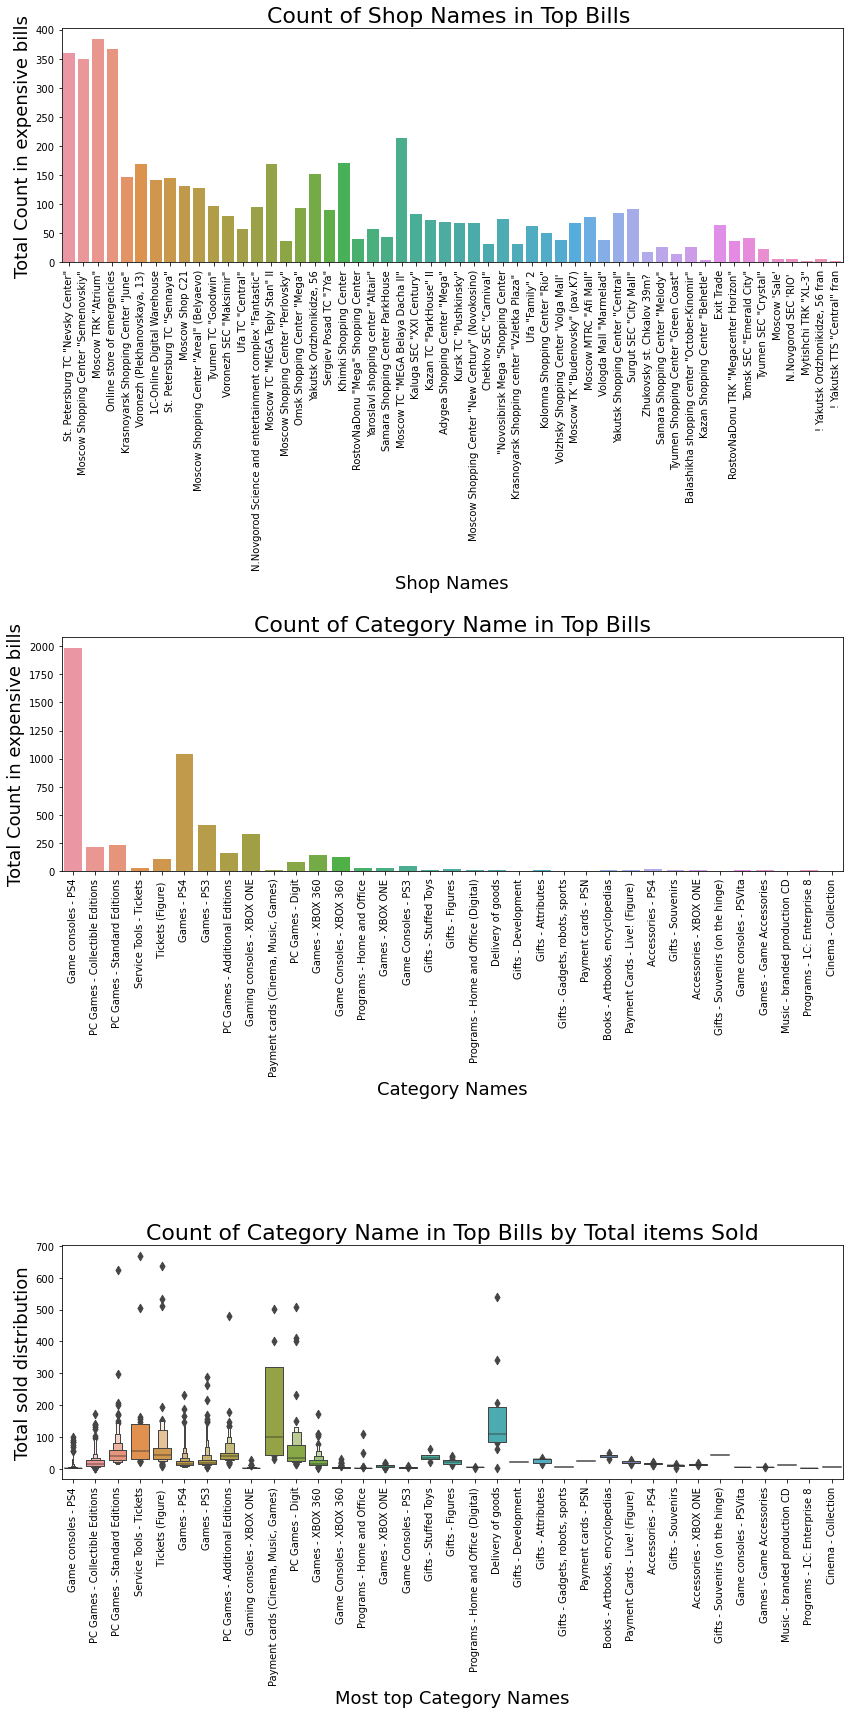

In [ ]:
plt.figure(figsize=(14,26))

plt.subplot(311)
g = sns.countplot(x='shop_name', data=sub_categorys_5000)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_title("Count of Shop Names in Top Bills ", fontsize=22)
g.set_xlabel('Shop Names', fontsize=18)
g.set_ylabel("Total Count in expensive bills", fontsize=18)

plt.subplot(312)
g = sns.countplot(x='item_category_name', data=sub_categorys_5000)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_title("Count of Category Name in Top Bills", fontsize=22)
g.set_xlabel('Category Names', fontsize=18)
g.set_ylabel("Total Count in expensive bills", fontsize=18)

plt.subplot(313)
g = sns.boxenplot(x='item_category_name', y='item_cnt_day', data=sub_categorys_5000)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_title("Count of Category Name in Top Bills by Total items Sold", fontsize=22)
g.set_xlabel('Most top Category Names', fontsize=18)
g.set_ylabel("Total sold distribution", fontsize=18)

plt.subplots_adjust(wspace = 0.2, hspace = 1.6,top = 0.9)

plt.show()

Some of this values has just one unit sold, and I will see it now

## The most expensive products

In [ ]:
df_train[['item_category_name', 'item_name', 'shop_name', 'item_cnt_day', 'item_price']].nlargest(15, 'item_price')

,item_category_name,item_name,shop_name,item_cnt_day,item_price
2678303,Programs - Home and Office,Radmin 3 - 522 лиц.,Online store of emergencies,1.0,307980.0
2693298,Delivery of goods,Доставка (EMS),Online store of emergencies,1.0,59200.0
355222,Gifts - Souvenirs,Коллекционные шахматы (Властелин Колец),"Moscow TRK ""Atrium""",1.0,50999.0
2678339,Programs - Home and Office,UserGate Proxy & Firewall 6.X с модулем фильтр...,Online store of emergencies,1.0,49782.0
1073299,Gaming consoles - XBOX ONE,"Комплект ""Microsoft Xbox One 1TB Limited Edit...","St. Petersburg TC ""Nevsky Center""",1.0,42990.0
2005340,Gaming consoles - XBOX ONE,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",Moscow Shop C21,1.0,42990.0
2642052,Gaming consoles - XBOX ONE,"Комплект ""Microsoft Xbox One 1TB Limited Edit...","Balashikha shopping center ""October-Kinomir""",1.0,42990.0
2697533,Gaming consoles - XBOX ONE,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",Online store of emergencies,1.0,42990.0
2678292,Programs - Home and Office,UserGate Proxy & Firewall 6.X до 100 сессий,Online store of emergencies,1.0,42000.0
1120510,Gaming consoles - XBOX ONE,"Комплект ""Microsoft Xbox One 1TB Limited Edit...","Omsk Shopping Center ""Mega""",1.0,41990.0


Hummm... We have a high GAP between the most expensive item to other items. 
I will see how many of total are of 1 unit item sold


In [ ]:
print(f"Total of solds that have only one unit: {round(len(df_train[df_train.item_cnt_day == 1]) / len(df_train) * 100,2)}%")

Total of solds that have only one unit: 89.56%


## Category's by items sold by day - Crosstab

In [ ]:
cross_heatmap(sub_categorys_5000, ['item_category_name', 'item_cnt_day'])

Very interesting patterns. We can see that some items aren't sold only one unit. Maybe some people buy to resell the games or consoles

## TOP 25 items Solds
- Let's understand the principal itens sold at the dataset
- The distribution of Total amount and Item Solds in the bill

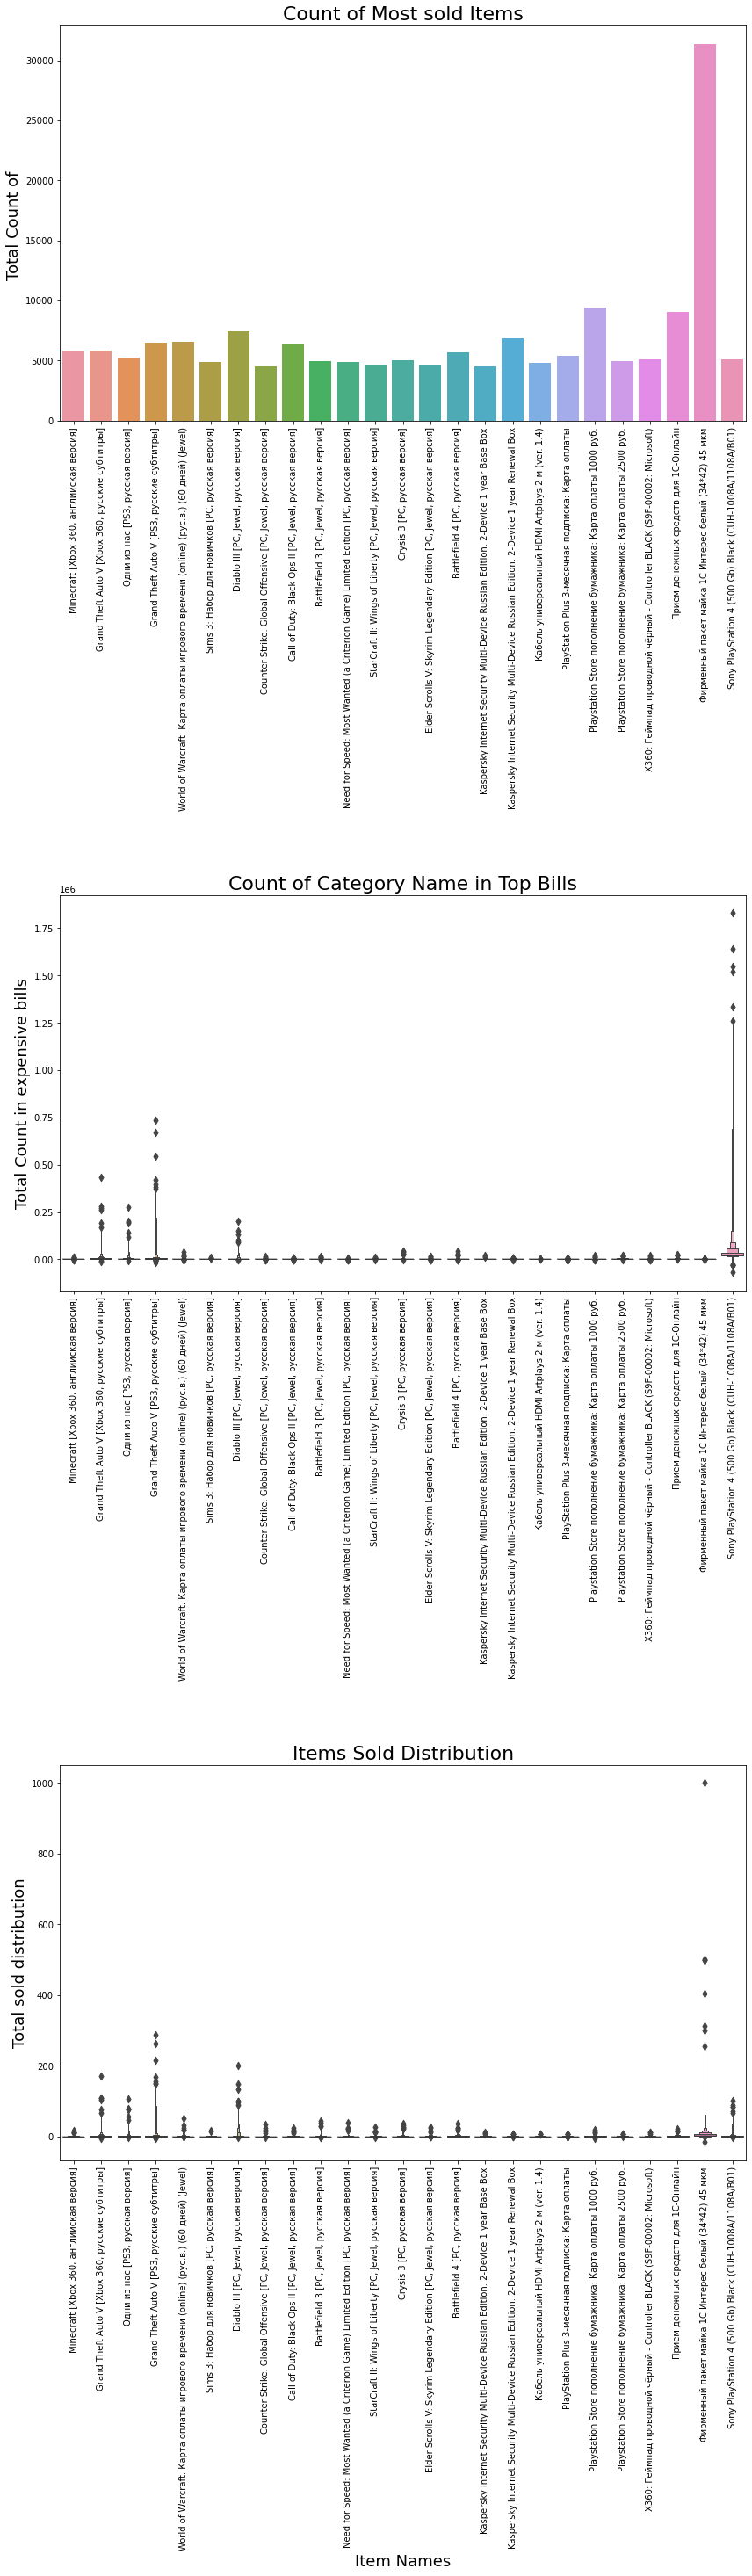

In [ ]:
count_item = df_train.item_name.value_counts()[:25]

plt.figure(figsize=(14,50))

plt.subplot(311)
g = sns.countplot(x='item_name', data=df_train[df_train.item_name.isin(count_item.index)])
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_title("Count of Most sold Items", fontsize=22)
g.set_xlabel('', fontsize=18)
g.set_ylabel("Total Count of ", fontsize=18)

plt.subplot(312)
g1 = sns.boxenplot(x='item_name', y='total_amount',
                  data=df_train[df_train.item_name.isin(count_item.index)])
g1.set_xticklabels(g1.get_xticklabels(),rotation=90)
g1.set_title("Count of Category Name in Top Bills", fontsize=22)
g1.set_xlabel('', fontsize=18)
g1.set_ylabel("Total Count in expensive bills", fontsize=18)

plt.subplot(313)
g2 = sns.boxenplot(x='item_name', y='item_cnt_day', 
                  data=df_train[df_train.item_name.isin(count_item.index)])
g2.set_xticklabels(g2.get_xticklabels(),rotation=90)
g2.set_title("Items Sold Distribution", fontsize=22)
g2.set_xlabel('Item Names', fontsize=18)
g2.set_ylabel("Total sold distribution", fontsize=18)

plt.subplots_adjust(wspace = 0.2, hspace = 1.2,top = .8)

plt.show()

## Understanding the revenue for each Shop Name. 

In [ ]:
cross_heatmap(df_train.sample(500000), ['item_category_name', 'shop_name'], 
              normalize='columns', aggfunc='sum', values=df_train['total_amount'])

## Time series
- Exploring some metrics abuot the datetime feature

In [ ]:

df_train['date'].value_counts().to_frame().reset_index().sort_values('index')

,index,date
924,2013-01-01,1669
10,2013-01-02,6718
15,2013-01-03,6298
26,2013-01-04,5634
31,2013-01-05,5545
...,...,...
1011,2015-10-27,1361
1022,2015-10-28,1238
1004,2015-10-29,1405
826,2015-10-30,1938


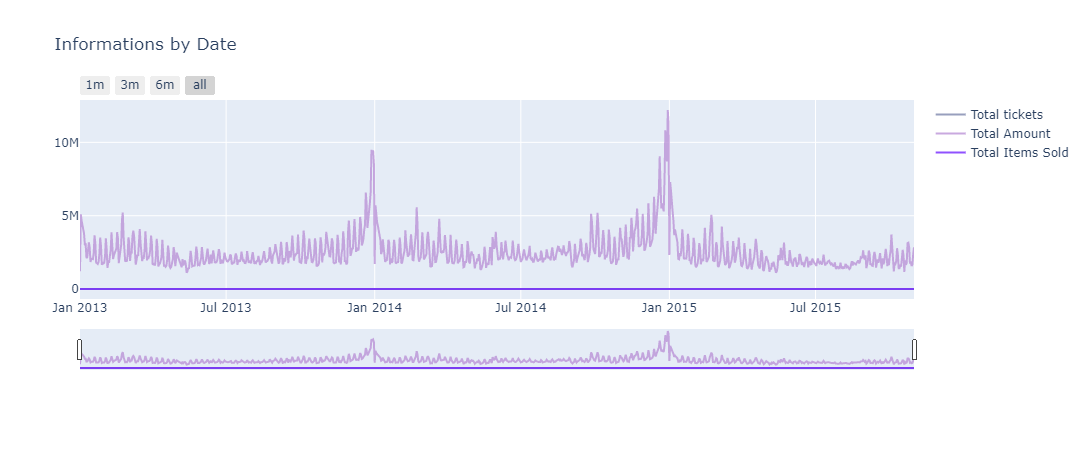

In [ ]:
# Calling the function to transform the date column in datetime pandas object
#df_train = date_process(df_train)

#seting some static color options
color_op = ['#5527A0', '#BB93D7', '#834CF7', '#6C941E', '#93EAEA', '#7425FF', '#F2098A', '#7E87AC', 
            '#EBE36F', '#7FD394', '#49C35D', '#3058EE', '#44FDCF', '#A38F85', '#C4CEE0', '#B63A05', 
            '#4856BF', '#F0DB1B', '#9FDBD9', '#B123AC']


dates_temp = df_train['date'].value_counts().to_frame().reset_index().sort_values('index') 
# renaming the columns to apropriate names
dates_temp = dates_temp.rename(columns = {"date" : "Total_Bills"}).rename(columns = {"index" : "date"})

# creating the first trace with the necessary parameters
trace = go.Scatter(x=dates_temp.date.astype(str), y=dates_temp.Total_Bills,
                    opacity = 0.8, line = dict(color = color_op[7]), name= 'Total tickets')

# Below we will get the total amount sold
dates_temp_sum = df_train.groupby('date')['item_price'].sum().to_frame().reset_index()

# using the new dates_temp_sum we will create the second trace
trace1 = go.Scatter(x=dates_temp_sum.date.astype(str), line = dict(color = color_op[1]), name="Total Amount",
                        y=dates_temp_sum['item_price'], opacity = 0.8)

# Getting the total values by Transactions by each date
dates_temp_count = df_train[df_train['item_cnt_day'] > 0].groupby('date')['item_cnt_day'].sum().to_frame().reset_index()

# using the new dates_temp_count we will create the third trace
trace2 = go.Scatter(x=dates_temp_count.date.astype(str), line = dict(color = color_op[5]), name="Total Items Sold",
                        y=dates_temp_count['item_cnt_day'], opacity = 0.8)

#creating the layout the will allow us to give an title and 
# give us some interesting options to handle with the outputs of graphs
layout = dict(
    title= "Informations by Date",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=3, label='3m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible = True),
        type='date'
    )
)

# creating figure with the both traces and layout
fig = dict(data= [trace, trace1, trace2], layout=layout)

#rendering the graphs
iplot(fig) #it's an equivalent to plt.show()

We can see that one specific day had an peak in sales. I put it on google and I don't find anything about this date. 

## Understanding the sales by month

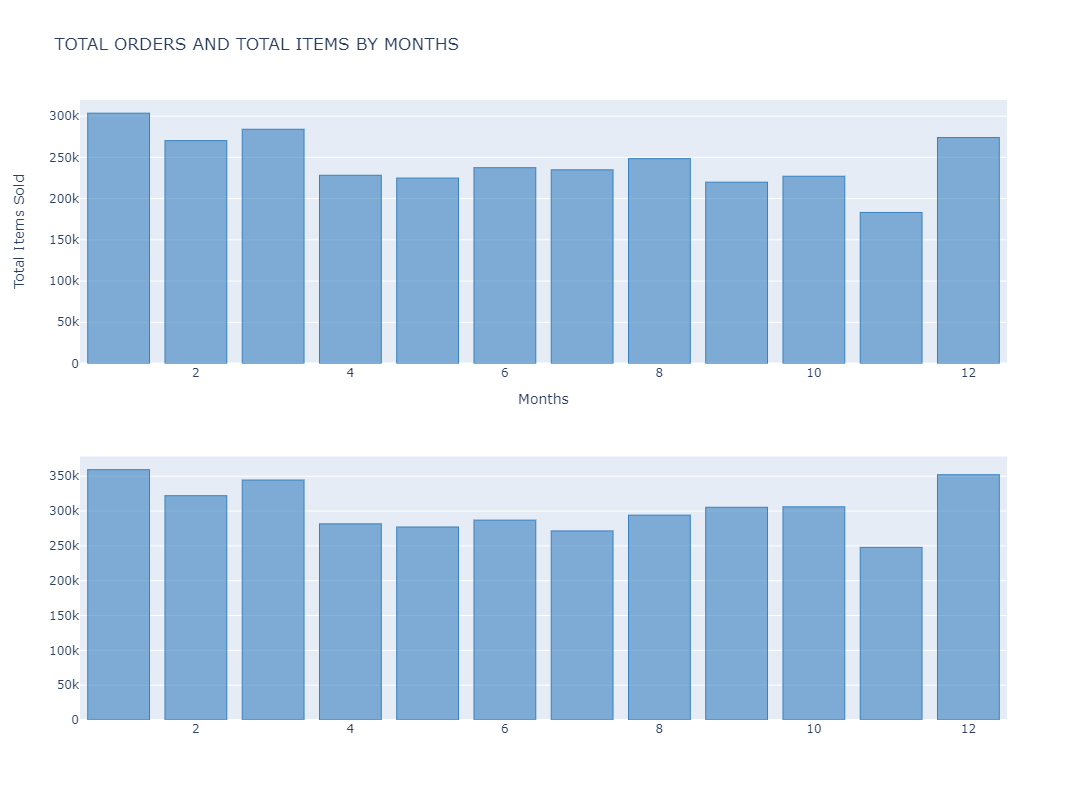

In [ ]:


def generate_random_color():
    r = lambda: random.randint(0,255)
    return '#%02X%02X%02X' % (r(),r(),r())

#shared Xaxis parameter can make this graph look even better
fig = pls.make_subplots(rows=2, cols=1)

layout1 = cf.Layout(
    height=500,
    width=200
)
animal_color = generate_random_color()
fig1 = df_train.groupby(['_month'])['item_cnt_day'].count().iplot(kind='bar',barmode='stack',
                                                                  asFigure=True,showlegend=False,
                                                                  title='Total Items Sold By Month',
                                                                  xTitle='Months', yTitle='Total Items Sold',
                                                                  color = 'blue')
fig1['data'][0]['showlegend'] = False
fig.append_trace(fig1['data'][0], 1, 1)


fig2 = df_train.groupby(['_month'])['item_cnt_day'].sum().iplot(kind='bar',barmode='stack',
                                                                title='Total orders by Month',
                                                                xTitle='Months', yTitle='Total Orders',
                                                                asFigure=True, showlegend=False, 
                                                                color = 'blue')

#if we do not use the below line there will be two legend
fig2['data'][0]['showlegend'] = False


fig.append_trace(fig2['data'][0], 2, 1)

layout = dict(
    title= "Informations by Date",
    )

fig['layout']['height'] = 800
fig['layout']['width'] = 1000
fig['layout']['title'] = "TOTAL ORDERS AND TOTAL ITEMS BY MONTHS"
fig['layout']['yaxis']['title'] = "Total Items Sold"
fig['layout']['xaxis']['title'] = "Months"
fig['layout']

iplot(fig)

In [ ]:
df_train['diff_days'] = df_train.groupby(['shop_name','item_category_name']).date.diff().dt.days.fillna(0, downcast='infer')

In [ ]:
df_train['diff_days']

0            0
1          114
2           61
3           24
4           56
          ... 
2935844      2
2935845    -31
2935846     -5
2935847      6
2935848     34
Name: diff_days, Length: 2935849, dtype: int64

<AxesSubplot:>

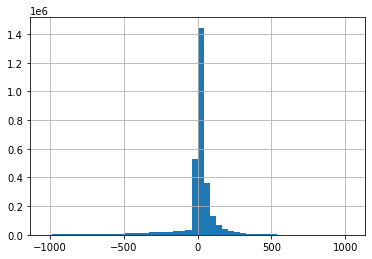

In [ ]:
df_train['diff_days'].hist(bins=50)

In [ ]:
grouped_blocks = df_train.groupby(["date_block_num",
                                    "shop_name","item_category_name"])["item_name",
                                                                       "item_price",
                                                                       "item_cnt_day"].agg({"item_name":["nunique", 'count'],
                                                                                            "item_price":["min",'mean','max'],
                                                                                            "item_cnt_day":["min",'mean','max','sum']})

In [ ]:
grouped_blocks.head(15)

item_name  \
                                                                                  nunique   
date_block_num shop_name                        item_category_name                          
0              ! Yakutsk Ordzhonikidze, 56 fran Accessories - PS3                      16   
                                                Accessories - PS4                       1   
                                                Accessories - PSP                       5   
                                                Accessories - PSVita                   11   
                                                Accessories - XBOX 360                 10   
                                                Batteries                               3   
                                                Books - Audiobooks                     52   
                                                Books - Audiobooks 1C                  10   
                                                Books - Methodical materials 1C         4   
                                                Cinema - Blu-Ray                      209   
                                                Cinema - Blu-Ray 3D                    37   
                                                Cinema - Collection                    65   
                                                Cinema - DVD                          833   
                                                Game Consoles - PS3                     8   
                                                Game Consoles - XBOX 360                3   

                                                                                       \
                                                                                count   
date_block_num shop_name                        item_category_name                      
0              ! Yakutsk Ordzhonikidze, 56 fran Accessories - PS3                  45   
                                                Accessories - PS4                  18   
                                                Accessories - PSP                  14   
                                                Accessories - PSVita               26   
                                                Accessories - XBOX 360             55   
                                                Batteries                          12   
                                                Books - Audiobooks                 53   
                                                Books - Audiobooks 1C              13   
                                                Books - Methodical materials 1C     4   
                                                Cinema - Blu-Ray                  283   
                                                Cinema - Blu-Ray 3D                46   
                                                Cinema - Collection                87   
                                                Cinema - DVD                     1570   
                                                Game Consoles - PS3                22   
                                                Game Consoles - XBOX 360            6   

                                                                                item_price  \
                                                                                       min   
date_block_num shop_name                        item_category_name                           
0              ! Yakutsk Ordzhonikidze, 56 fran Accessories - PS3                    294.0   
                                                Accessories - PS4                    242.0   
                                                Accessories - PSP                     44.0   
                                                Accessories - PSVita                 102.0   
                                                Accessories - XBOX 360               263.0   
                                                Ba